# Example of using the IDR web API

OMERO.web uses a default session backend authentication
scheme to authenticate.
First create a HTTP session using the
[`requests`](http://docs.python-requests.org/en/master/) library:

In [2]:
from IPython.display import display, HTML
import requests
# initial data
IDR_BASE_URL = "https://idr.openmicroscopy.org"


In [3]:
INDEX_PAGE = "%s/webclient/?experimenter=-1" % IDR_BASE_URL
# create http session
with requests.Session() as session:
    request = requests.Request('GET', INDEX_PAGE)
    prepped = session.prepare_request(request)
    response = session.send(prepped)
    if response.status_code != 200:
        response.raise_for_status()

# Studies:

## Get Study map annotation:

In [4]:
MAP_URL = "{base}/webclient/api/annotations/?type=map&{type}={screen_id}"

SCREEN_ID = 102

qs = {'base': IDR_BASE_URL, 'type': 'screen', 'screen_id': SCREEN_ID}
url = MAP_URL.format(**qs)
for a in session.get(url).json()['annotations']:
    namespace = a['ns']
    for v in a['values']:
        key = v[0]
        value = v[1]
        print(key, value)

Sample Type cell
Organism Homo sapiens
Study Title Focused mitotic chromsome condensaton screen using HeLa cells
Study Type high content screen
Screen Type primary screen
Screen Technology Type RNAi screen
Imaging Method fluorescence microscopy
Publication Title Integration of biological data by kernels on graph nodes allows prediction of new genes involved in mitotic chromosome condensation.
Publication Authors Hériché JK, Lees JG, Morilla I, Walter T, Petrova B, Roberti MJ, Hossain MJ, Adler P, Fernández JM, Krallinger M, Haering CH, Vilo J, Valencia A, Ranea JA, Orengo C, Ellenberg J
PubMed ID 24943848 https://www.ncbi.nlm.nih.gov/pubmed/24943848
PMC ID PMC4142622 https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4142622
Publication DOI 10.1091/mbc.E13-04-0221 https://doi.org/10.1091/mbc.E13-04-0221
Release Date 2016-05-26
License CC BY 4.0 https://creativecommons.org/licenses/by/4.0/
Copyright Heriche et al
Annotation File idr0002-screenA-annotation.csv https://github.com/IDR/idr0002-he

## Get Plates in the given Screen:

In [5]:
PLATES_URL = "{base}/webclient/api/plates/?id={screen_id}"

SCREEN_ID = 102

qs = {'base': IDR_BASE_URL, 'screen_id': SCREEN_ID}
url = PLATES_URL.format(**qs)
for p in session.get(url).json()['plates']:
    plate_id = p['id']
    print("Plate: {id}, Name: {name}, Children: {childCount}".format(**p))

Plate: 422, Name: plate1_1_013, Children: 1
Plate: 492, Name: plate1_2_006, Children: 1
Plate: 559, Name: plate1_3_003, Children: 1
Plate: 620, Name: plate1_7_015, Children: 1
Plate: 680, Name: plate2_2_007, Children: 1
Plate: 728, Name: plate2_3_018, Children: 1
Plate: 800, Name: plate2_5_015, Children: 1
Plate: 869, Name: plate2_7_028, Children: 1
Plate: 944, Name: plate3_11_007, Children: 1
Plate: 1015, Name: plate3_4_034, Children: 1
Plate: 1072, Name: plate3_5_002, Children: 1
Plate: 4554, Name: plate3_8_010, Children: 1


## Get PlateGrid:

In [6]:
WELLS_IMAGES_URL = "{base}/webgateway/plate/{plate_id}/{field}/"

qs = {'base': IDR_BASE_URL, 'plate_id': plate_id, 'field': 0}
url = WELLS_IMAGES_URL.format(**qs)
grid = session.get(url).json()
rowlabels = grid['rowlabels']
collabels = grid['collabels']
for row in grid['grid']:
    for cell in row:
        if cell is not None:
            print("Well: {wellId}, Image: {id}".format(**cell))


Well: 1046859, Image: 1938559
Well: 1046944, Image: 1938650
Well: 1046877, Image: 1938583
Well: 1046904, Image: 1938610
Well: 1046910, Image: 1938616
Well: 1046869, Image: 1938575
Well: 1046864, Image: 1938570
Well: 1046940, Image: 1938646
Well: 1046930, Image: 1938636
Well: 1046853, Image: 1938560
Well: 1046920, Image: 1938626
Well: 1046863, Image: 1938569
Well: 1046890, Image: 1938596
Well: 1046889, Image: 1938595
Well: 1046942, Image: 1938648
Well: 1046915, Image: 1938621
Well: 1046934, Image: 1938640
Well: 1046880, Image: 1938586
Well: 1046881, Image: 1938587
Well: 1046919, Image: 1938625
Well: 1046870, Image: 1938576
Well: 1046947, Image: 1938653
Well: 1046892, Image: 1938598
Well: 1046856, Image: 1938563
Well: 1046900, Image: 1938606
Well: 1046901, Image: 1938607
Well: 1046945, Image: 1938651
Well: 1046873, Image: 1938579
Well: 1046936, Image: 1938642
Well: 1046908, Image: 1938614
Well: 1046897, Image: 1938603
Well: 1046867, Image: 1938573
Well: 1046865, Image: 1938571
Well: 1046

## Get Image Thumbnail:

,,,,,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,,,,,

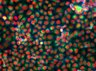
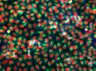
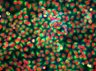
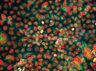
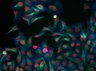
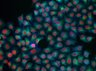
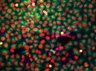
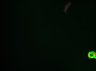
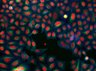
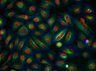
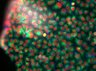
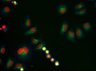
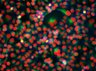
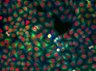
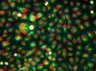
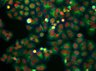
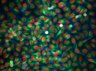
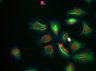
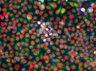
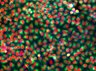
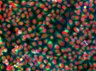
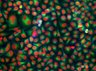
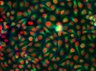
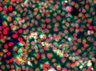
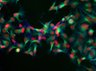
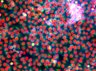
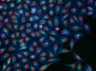
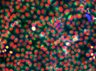
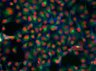
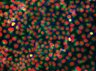
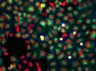
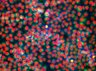
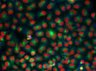
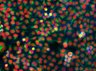
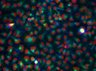
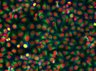
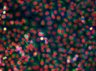
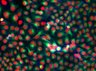
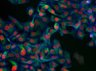
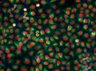
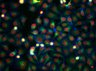
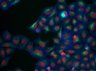
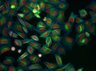
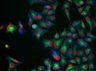
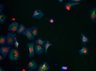
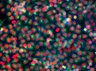
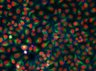
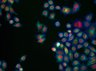
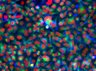
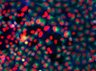
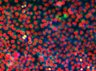
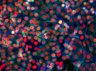
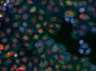
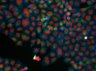
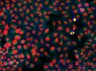
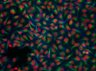
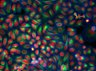
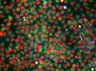
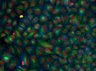
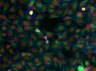
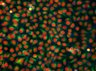
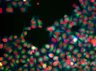
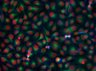
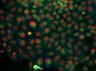
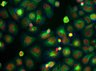
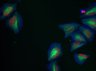
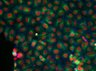
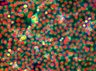
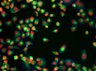
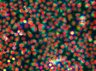
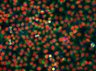
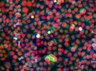
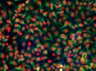
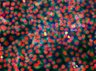
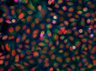
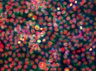
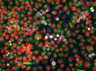
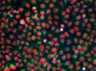
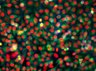
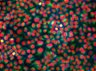
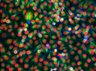
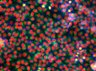
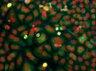
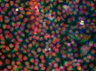
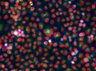
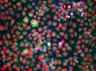
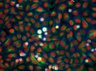
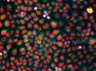
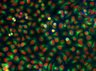
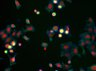
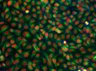
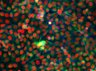
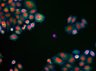
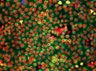
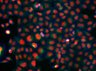
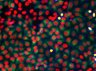
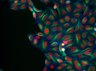
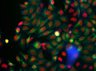
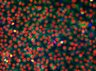
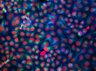
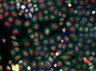
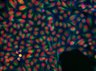
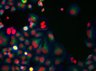
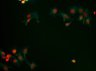
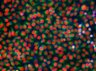
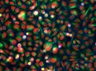
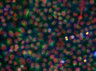
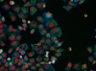
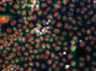
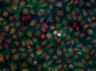
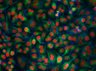
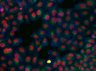
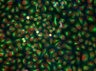
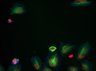
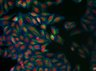
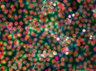
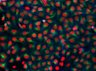
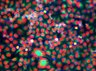
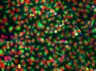
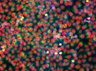
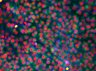
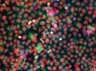
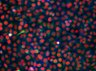
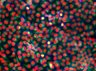
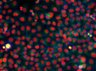
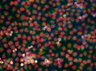
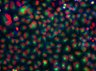
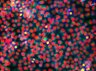
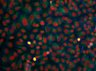
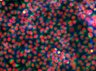
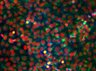
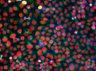
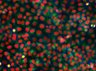
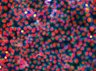
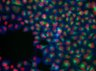
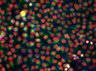
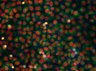
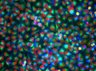
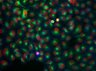
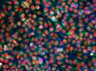
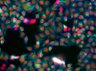
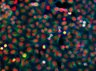
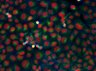
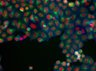
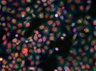
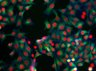
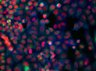
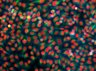
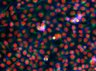
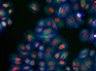
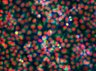
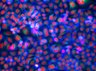
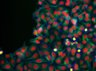
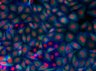
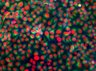
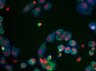
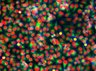
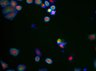
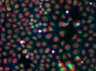
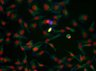
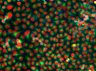
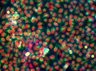
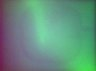
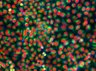
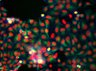
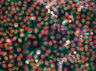
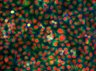
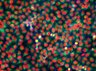
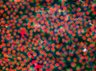
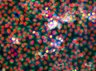
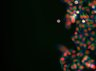
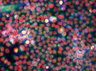
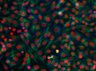
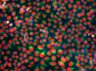
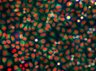
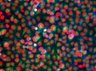
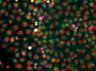
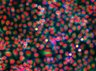
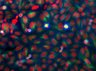
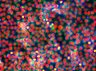
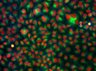
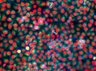
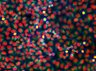
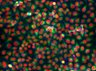
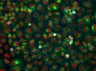
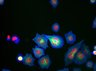
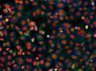
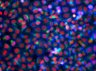
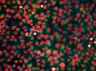
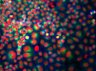
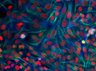
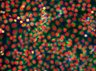
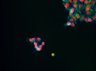
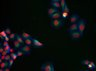
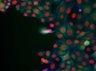
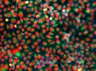
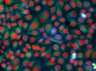
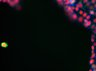
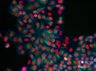
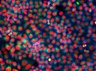
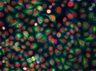
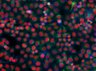
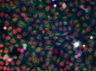
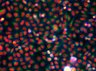
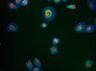
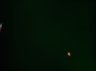
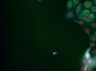
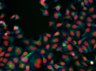
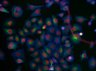
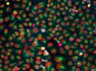
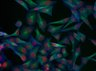
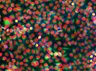
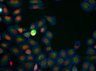
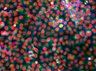
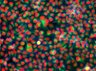
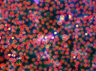
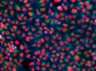
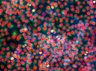
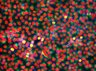
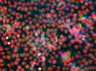
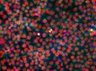
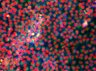
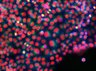
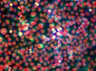
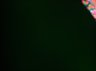
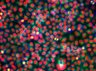
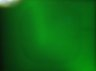
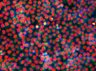
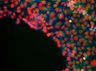
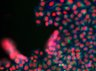
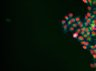
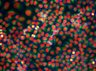
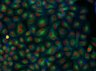
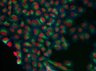
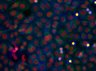
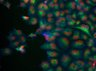
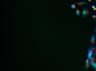
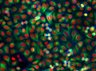
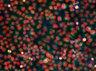
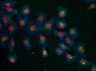
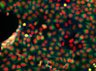
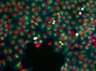
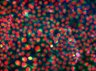
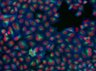
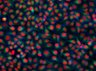
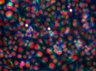
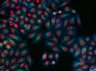
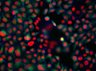
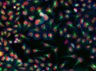
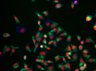
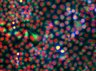
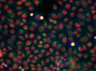
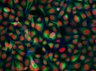
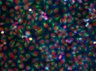
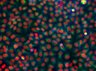
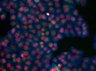
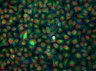
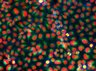
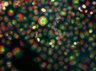
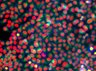
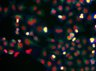
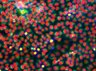
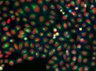
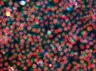
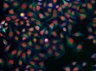
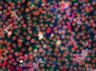
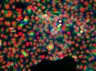
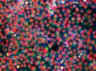
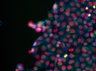
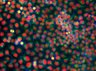
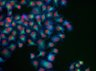
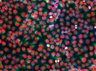
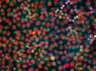
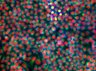
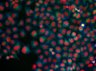
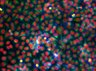
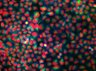
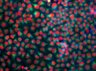
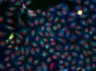
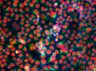
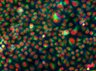
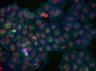
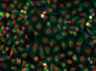
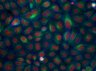
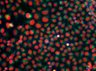
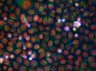
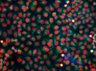
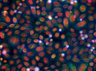
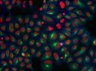
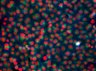
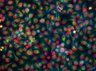
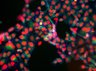
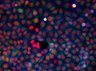
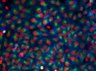
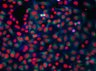
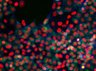
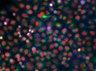
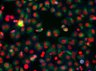
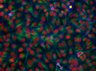
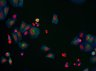
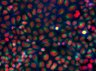
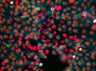
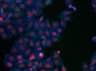
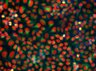
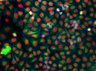
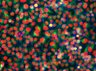
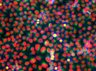
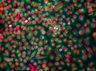
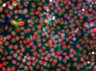
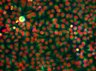
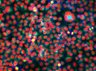
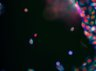
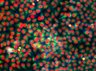
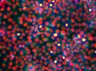
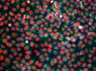
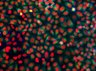
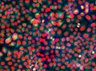
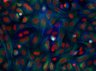
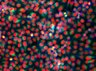
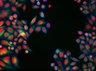
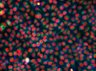
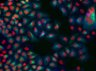
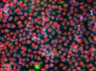
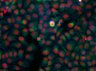
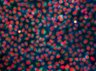
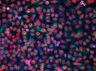
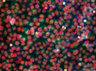
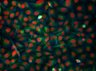
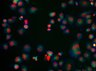
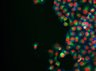
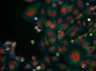
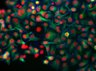
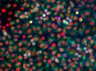
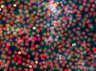
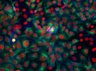
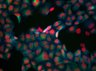
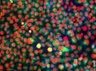
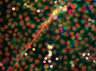
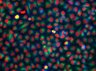
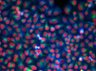
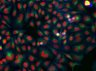
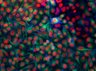
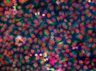
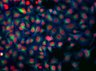
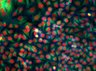
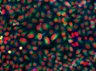
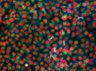
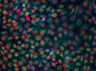
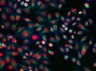
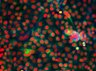
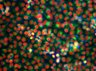
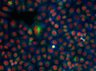
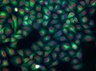
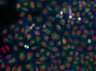
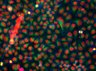
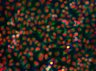
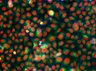
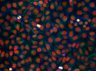
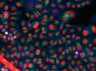
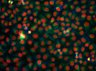
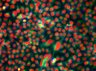
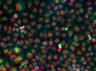
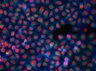
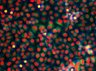
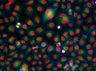
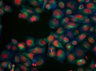
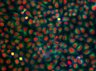
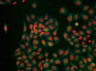
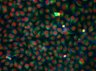
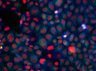
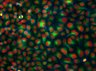
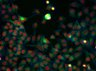
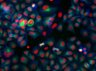
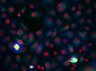
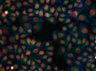
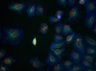

In [7]:
WELLS_IMAGES_URL = "{base}/webgateway/plate/{plate_id}/{field}/"
PLATE_ID = 325

qs = {'base': IDR_BASE_URL, 'plate_id': PLATE_ID, 'field': 0}
url = WELLS_IMAGES_URL.format(**qs)
grid = session.get(url).json()

image_ids = [cell['id'] for row in grid['grid']
             for cell in row if cell is not None]

THUMBNAILS_URL = "{base}/webgateway/get_thumbnails/".format(**{'base': IDR_BASE_URL, })  # noqa


def thumbnails_chunk(image_list, batch):
    for b in range(0, len(image_list), batch):
        yield image_list[b:b + batch]


batch_size = 20

_thumbnails = {}
for batch in thumbnails_chunk(image_ids, batch_size):
    payload = {'id': batch}
    json = session.get(THUMBNAILS_URL, params=payload).json()
    for iid, thumb in json.items():
        _thumbnails[int(iid)] = thumb

# Display plate
_tbody = []
for row in grid['grid']:
    _tr = ["<tr>"]
    for cell in row:
        if cell is not None:
            _tr.append('<td><img src="%s"/></td>' % _thumbnails[cell['id']])
        else:
            _tr.append('<td></td>')
    _tr.append("</tr>")
    _tbody.append("&nbsp;".join(_tr))
display(HTML("<table>" + "".join(_tbody) + "</table>"))

## Get Image:

In [8]:
IMAGE_DETAILS_URL = "{base}/webclient/imgData/{image_id}/"

IMAGE_ID = 122770

qs = {'base': IDR_BASE_URL, 'image_id': IMAGE_ID}
url = IMAGE_DETAILS_URL.format(**qs)
r = session.get(url)
if r.status_code == 200:
    print(r.json())

RENDER_IMAGE = "{base}/webgateway/render_image/{image_id}/0/0/"
img_url = RENDER_IMAGE.format(**qs)

display(HTML("<img src='%s' />" % img_url))

{'id': 122770, 'meta': {'imageName': 'Plate8_Actinome1 [Well O02 Field #1]', 'imageDescription': '', 'imageAuthor': 'Public data', 'projectName': 'Multiple', 'projectId': None, 'projectDescription': '', 'datasetName': 'Multiple', 'datasetId': None, 'datasetDescription': '', 'wellSampleId': '', 'wellId': 45217, 'imageTimestamp': 1194540393.0, 'imageId': 122770, 'pixelsType': 'uint16'}, 'perms': {'canAnnotate': False, 'canEdit': False, 'canDelete': False, 'canLink': False}, 'tiles': False, 'interpolate': True, 'size': {'width': 696, 'height': 520, 'z': 1, 't': 1, 'c': 3}, 'pixel_size': {'x': 1.25195005, 'y': 1.25195005, 'z': None}, 'init_zoom': 0, 'pixel_range': [0, 65535], 'channels': [{'emissionWave': None, 'label': 'DAPI', 'color': 'FF0000', 'inverted': False, 'reverseIntensity': False, 'family': 'linear', 'coefficient': 1.0, 'window': {'min': 250.0, 'max': 4095.0, 'start': 250.0, 'end': 4095.0}, 'active': True}, {'emissionWave': None, 'label': 'FITC-FilterWheel', 'color': '00FF00', '

## Get Image map annotation:

In [9]:
MAP_URL = "{base}/webclient/api/annotations/?type=map&{type}={image_id}"

IMAGE_ID = 122770

qs = {'base': IDR_BASE_URL, 'type': 'image', 'image_id': IMAGE_ID}
url = MAP_URL.format(**qs)
for a in session.get(url).json()['annotations']:
    namespace = a['ns']
    for v in a['values']:
        key = v[0]
        value = v[1]
        print(key, value)

Cell Line HeLa
Gene Identifier NM_018098
Gene Identifier URL http://www.ncbi.nlm.nih.gov/nuccore/NM_018098
Gene Symbol ECT2
Analysis Gene Annotation Build siRNA Pool Identifiers/Gene symbols from GRCh37, Ensembl release 56, Sept 2009
Gene Annotation Comments Gene Symbol added using siRNA Pool Identifier name by IDR curator
Organism Homo sapiens
Phenotype increased actin over nucleus
Phenotype Term Name increased actin localised to the nucleus
Phenotype Term Accession CMPO_0000294
Phenotype Term Accession URL http://www.ebi.ac.uk/cmpo/CMPO_0000294
Phenotype increased number of multinucleate cells
Phenotype Term Name more multinucleate cells
Phenotype Term Accession CMPO_0000300
Phenotype Term Accession URL http://www.ebi.ac.uk/cmpo/CMPO_0000300
Phenotype increased number of zigzag actin stress fibres
Phenotype Term Name increased amount of zig-zag stress fibers
Phenotype Term Accession CMPO_0000299
Phenotype Term Accession URL http://www.ebi.ac.uk/cmpo/CMPO_0000299
Phenotype increased D

## Get bulk annotation:

In [10]:
BULK_URL = "{base}/webgateway/table/Screen.plateLinks.child.wells/{well_id}/query/?query=Well-{well_id}"  # noqa

WELL_ID = 45217
qs = {'base': IDR_BASE_URL, 'well_id': WELL_ID}
url = BULK_URL.format(**qs)
r = session.get(url)
print(r.json())


# or download entire bulk_annotation file:

FILEANNOTATION_URL = "{base}/webclient/api/annotations/?type=file&screen={screen_id}"  # noqa
DOWNLOAD_URL = "{base}/webclient/annotation/{ann_id}"

SCREEN_ID = 206

qs = {'base': IDR_BASE_URL, 'screen_id': SCREEN_ID}
url = FILEANNOTATION_URL.format(**qs)
for a in session.get(url).json()['annotations']:
    namespace = a['ns']
    ann_id = a['id']
    qs2 = {'base': IDR_BASE_URL, 'ann_id':  a['id']}
    url2 = DOWNLOAD_URL.format(**qs2)
    print("Download URL:", url2)

{'data': {'column_types': ['PlateColumn', 'StringColumn', 'WellColumn', 'StringColumn', 'StringColumn', 'StringColumn', 'StringColumn', 'StringColumn', 'StringColumn', 'StringColumn', 'StringColumn', 'StringColumn', 'StringColumn', 'StringColumn', 'StringColumn', 'StringColumn', 'StringColumn', 'StringColumn', 'StringColumn', 'StringColumn', 'StringColumn', 'StringColumn', 'StringColumn', 'StringColumn', 'StringColumn', 'StringColumn', 'StringColumn', 'StringColumn', 'StringColumn', 'StringColumn', 'StringColumn', 'StringColumn', 'StringColumn', 'StringColumn', 'StringColumn', 'StringColumn', 'StringColumn', 'StringColumn', 'StringColumn', 'StringColumn', 'StringColumn', 'StringColumn', 'StringColumn', 'StringColumn', 'StringColumn', 'StringColumn', 'StringColumn', 'StringColumn', 'StringColumn', 'StringColumn', 'StringColumn', 'StringColumn', 'StringColumn', 'StringColumn', 'StringColumn', 'StringColumn', 'StringColumn', 'StringColumn', 'StringColumn', 'StringColumn', 'StringColumn', 

# Attributes (e.g. Gene Symbol, Phenotype Term Accession...)

## Load all the possible values associated to a specific key e.g. Gene Symbol:

In [12]:
KEYS_SEARCH = "https://idr.openmicroscopy.org/searchengine/api/v1/resources/{type}/searchvaluesusingkey/?key={key}"
# Key used by search engine
KEY = "Gene Symbol"

values = []
qs1 = {'type': 'image', 'key': KEY}
url = KEYS_SEARCH.format(**qs1)  
json = session.get(url).json()
for d in json['data']:
    if d['Value']:
        values.append(d['Value'])
values.sort()
print(values)

[' ciz1', ' spen', '128up', '14-3-3epsilon', '14-3-3zeta', '140up', '15e2_human', '18w', '26-29-p', '2mit', '312', '4ehp', '5-ht1a', '5-ht1b', '5-ht2', '5-ht2a', '5-ht2b', '5-ht7', '5ptasei', '76p', '7a5', '7b2', '7h3', '825-oak', 'a', 'a10', 'a16', 'a1bg', 'a1bg-as1', 'a1cf', 'a1l167_human', 'a2agn1_human', 'a2bp1', 'a2bp1_human', 'a2ld1', 'a2m', 'a2m-as1', 'a2ml1', 'a2rum1_human', 'a3-3', 'a3galt2', 'a4galt', 'a4gnt', 'a5', 'a6', 'aaas', 'aac1', 'aac11', 'aac3', 'aacs', 'aad10', 'aad14', 'aad15', 'aad16', 'aad3', 'aad4', 'aad6', 'aadac', 'aadacl1', 'aadacl2', 'aadacl3', 'aadacl4', 'aadat', 'aaed1', 'aagab', 'aah1', 'aah3', 'aak1', 'aamdc', 'aamp', 'aanat', 'aap1', 'aar2', 'aars', 'aars2', 'aarsd1', 'aasdh', 'aasdhppt', 'aass', 'aat', 'aat1', 'aat2', 'aatf', 'aatk', 'aatk-as1', 'aats-ala', 'aats-ala-m', 'aats-arg', 'aats-asn', 'aats-asp', 'aats-cys', 'aats-gln', 'aats-glupro', 'aats-gly', 'aats-his', 'aats-ile', 'aats-leu', 'aats-lys', 'aats-met', 'aats-phe', 'aats-pro', 'aats-ser', '

## Get Images that are annotated with gene:

In [21]:
IMAGE_URL = "{base}/webclient/?show=image-{image_id}"
IMAGE_VIEWER = "{base}/webclient/img_detail/{image_id}/"
THUMBNAIL_URL = "{base}/webclient/render_thumbnail/{image_id}/"
ATTRIBUTES_URL = "{base}/webclient/api/annotations/?type=map&image={image_id}"  # noqa

KEY_VALUE_SEARCH = "https://idr.openmicroscopy.org/searchengine/api/v1/resources/{type}/search/?key={key}&value={value}"
gene = "ade8"
qs1 = {'type': 'image', 'key': KEY, 'value': gene}
url = KEY_VALUE_SEARCH.format(**qs1)  
json = session.get(url).json()
if 'results' in json['results']:
    images = json['results']['results']
    for image in images:
        image_id = image['id']
        print('Image link:', IMAGE_URL.format(**{'base': IDR_BASE_URL, 'image_id': image_id}))
        print('Image viewer link:', IMAGE_VIEWER.format(**{'base': IDR_BASE_URL, 'image_id': image_id}))
        print('Thumbnail URL:', THUMBNAIL_URL.format(**{'base': IDR_BASE_URL, 'image_id': image_id}))
        key_values = image['key_values']
        for k in key_values:
            print("%s, %s" % (k['name'], k['value']))


Image link: https://idr.openmicroscopy.org/webclient/?show=image-15573
Image viewer link: https://idr.openmicroscopy.org/webclient/img_detail/15573/
Thumbnail URL: https://idr.openmicroscopy.org/webclient/render_thumbnail/15573/
Gene Identifier, YDR408C
Organism, Saccharomyces cerevisiae
Phenotype, GFP localization: cytosol
Strain, Y6545
Environmental Stress, dithiothreitol
Gene Identifier URL, https://www.yeastgenome.org/locus/YDR408C
Phenotype Term Name, protein localized in cytosol phenotype
Channels, H2B-mCherry:cytosol;GFP:tagged protein;bright field/transmitted:cell
Gene Symbol, ADE8
Phenotype Term Accession, CMPO_0000393
Has Phenotype, yes
Phenotype Term Accession URL, http://www.ebi.ac.uk/cmpo/CMPO_0000393
Phenotype Annotation Level, experimental condition and gene
Image link: https://idr.openmicroscopy.org/webclient/?show=image-15574
Image viewer link: https://idr.openmicroscopy.org/webclient/img_detail/15574/
Thumbnail URL: https://idr.openmicroscopy.org/webclient/render_thum

### License (BSD 2-Clause)¶

Copyright (C) 2016-2021 University of Dundee. All Rights Reserved.

Redistribution and use in source and binary forms, with or without modification, are permitted provided that the following conditions are met:

Redistributions of source code must retain the above copyright notice, this list of conditions and the following disclaimer. Redistributions in binary form must reproduce the above copyright notice, this list of conditions and the following disclaimer in the documentation and/or other materials provided with the distribution. THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT OWNER OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.